# Adversarial training 

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-08-29 21:03:36.831577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 21:03:36.977286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 21:03:37.084367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 21:03:37.105396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 21:03:37.203694: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os
import shutil
import warnings
import splitfolders

warnings.filterwarnings('ignore')
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, BasicIterativeMethod

In [3]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

# Load dataset

In [4]:
base_dir = './dataset'
data_dir = './dataset/data'

In [5]:
train_dir = os.path.join(data_dir, 'train') ## Train Dataset
validation_dir = os.path.join(data_dir, 'val') ## Validation Dataset
test_dir = os.path.join(data_dir, 'test') ## Test Dataset

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

adversarial_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 6300 images belonging to 2 classes.
Found 1680 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'live': 0, 'spoof': 1}

Evaluate model accuracy on test data.

In [9]:
model = tf.keras.models.load_model('vgg19_msu_categorical.keras')

I0000 00:00:1724987026.650130  410359 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724987026.650264  410359 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724987026.650282  410359 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724987027.012577  410359 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724987027.012640  410359 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29

In [10]:
# evaluate the network
scores = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("Evaluate ", model.metrics_names[1], scores[1]*100))

I0000 00:00:1724987027.941876  410525 service.cc:146] XLA service 0x7f7a10005060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724987027.941974  410525 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-29 21:03:47.962980: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 21:03:48.078605: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-29 21:03:48.293708: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_243', 4 bytes spill stores, 4 bytes spill loads



 3/53 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 1.0000 - loss: 0.0094

I0000 00:00:1724987033.368306  410525 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9986 - loss: 0.0106
Evaluate compile_metrics: 99.82%


Create a ART Keras classifier for the TensorFlow Keras model.

In [11]:
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.losses import CategoricalCrossentropy

loss_object = CategoricalCrossentropy()

classifier = TensorFlowV2Classifier(model=model,
                                    clip_values=(0, 1), 
                                    nb_classes=2, 
                                    input_shape=(150, 150, 3), 
                                    loss_object=loss_object,
                                    optimizer = tf.keras.optimizers.Adam(),
                                    )

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,815,432 (79.40 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 527,366 (2.01 MB)

In [13]:
x_test, y_test = next(test_generator)

In [14]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)

nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_pred))

W0000 00:00:1724987046.566357  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987046.596991  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987046.610147  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987046.623691  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987046.636838  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987046.655813  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987046.668963  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987046.723927  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987046.740541  410359 gp

Original test data:
Correctly classified: 32
Incorrectly classified: 0


W0000 00:00:1724987049.637935  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987049.640083  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987049.642294  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987049.644094  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987049.646313  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987049.648230  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987049.650236  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987049.652166  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987049.654626  410359 gp

Evaluate on adversarial test data

In [15]:
attacker = FastGradientMethod(classifier, eps=0.1)
x_test_adv = attacker.generate(x_test, y_test)

W0000 00:00:1724987057.680431  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987057.682408  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987057.684343  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987057.686438  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987057.688629  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987057.692472  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987057.694454  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987057.698853  410359 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724987057.700786  410359 gp

In [16]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test, axis=1))

print("Adversarial test data:")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(len(x_test_adv)-nb_correct_adv_pred))

Adversarial test data:
Correctly classified: 4
Incorrectly classified: 28


### The model is not robust to adversarial examples generated with FGSM, with an eps = 0.1

# Adversarial training

In [17]:
attacks = BasicIterativeMethod(classifier, eps=0.3, eps_step=0.01, max_iter=40)

In [18]:
train_generator.samples // train_generator.batch_size

196

In [24]:
import h5py
import os
from IPython.display import clear_output

# Directory to save batches
save_dir = './adversarial_batches'
os.makedirs(save_dir, exist_ok=True)

# Create an HDF5 file to store the final dataset
hdf5_file = h5py.File(os.path.join(save_dir, 'final_dataset.h5'), 'w')

# Create datasets in the HDF5 file with appropriate shapes (initializing with empty data)
x_train_shape = (train_generator.samples * 2, 150, 150, 3)  # Original + adversarial
y_train_shape = (train_generator.samples * 2, 2)  # Adjust based on number of classes (2 in this case)

x_train_dataset = hdf5_file.create_dataset("x_train_all", x_train_shape, dtype='float32')
y_train_dataset = hdf5_file.create_dataset("y_train_all", y_train_shape, dtype='float32')

# Process and store batches
start_index = 0
for i, (x_train, y_train) in enumerate(train_generator):
    clear_output(wait=True)
    print(f'Processing batch {i+1}')
    
    # Generate adversarial examples
    x_train_adv = attacks.generate(x_train)
    
    # Ensure the shapes match for concatenation
    if x_train_adv.shape == x_train.shape:
        # Concatenate original and adversarial examples
        combined_x_train = np.concatenate((x_train, x_train_adv), axis=0)
        combined_y_train = np.concatenate((y_train, y_train), axis=0)
        
        # Write the current batch to HDF5 file
        batch_size = combined_x_train.shape[0]
        x_train_dataset[start_index:start_index+batch_size, ...] = combined_x_train
        y_train_dataset[start_index:start_index+batch_size, ...] = combined_y_train
        
        # Update the index for the next batch
        start_index += batch_size
    
    else:
        print(f"Shape mismatch: x_train shape = {x_train.shape}, x_train_adv shape = {x_train_adv.shape}")
        break
    
    # Stop after all batches have been processed
    if i >= train_generator.samples // train_generator.batch_size:
        break

# Close the HDF5 file after writing all batches
hdf5_file.close()

print(f"Final dataset saved in {os.path.join(save_dir, 'final_dataset.h5')}")

Processing batch 197


PGD - Batches: 0it [00:00, ?it/s]

Final dataset saved in ./adversarial_batches/final_dataset.h5


In [25]:
# Open the HDF5 file for reading
hdf5_file = h5py.File('./adversarial_batches/final_dataset.h5', 'r')

# Load the datasets
x_train_all = hdf5_file['x_train_all']
y_train_all = hdf5_file['y_train_all']

# Define a generator to yield batches of data
def data_generator(batch_size):
    num_samples = x_train_all.shape[0]
    while True:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            yield x_train_all[start_idx:end_idx], y_train_all[start_idx:end_idx]

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG19, EfficientNetB4
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the feature maps from ResNet50
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dense(2, activation='sigmoid')(x)  # Binary classification output layer

# Define the final model
model_robust = Model(inputs=base_model.input, outputs=x)

In [27]:
model_robust.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,288,066 (77.39 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [28]:
model_robust.compile(
        loss="categorical_crossentropy", 
        optimizer=Adam(),
    	metrics=["accuracy"]
    )

In [29]:
batch_size = 32
steps_per_epoch = x_train_all.shape[0] // batch_size

model_robust.fit(data_generator(batch_size), 
          steps_per_epoch=steps_per_epoch, 
          epochs=10,
          verbose=True
    )

Epoch 1/10


2024-08-29 22:22:15.256929: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1320', 36 bytes spill stores, 40 bytes spill loads

2024-08-29 22:22:15.263515: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1320', 32 bytes spill stores, 32 bytes spill loads

2024-08-29 22:22:15.276969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1320', 32 bytes spill stores, 32 bytes spill loads



393/393 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.9104 - loss: 0.2212
Epoch 2/10


2024-08-29 22:22:36.971757: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_935', 4 bytes spill stores, 4 bytes spill loads

2024-08-29 22:22:38.690985: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1320', 24 bytes spill stores, 24 bytes spill loads

2024-08-29 22:22:38.809375: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1320', 32 bytes spill stores, 32 bytes spill loads

2024-08-29 22:22:40.545306: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=2,k6=0,k13=2,k14=0,k22=1} for conv (f32[24,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,150,150]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}

393/393 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.9774 - loss: 0.0819
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.9842 - loss: 0.0549
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.9873 - loss: 0.0427
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.9906 - loss: 0.0337
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9922 - loss: 0.0261
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9935 - loss: 0.0214
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.9942 - loss: 0.0178
Epoch 9/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9954 - loss: 0.0149
Epoch 10/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9961 - loss: 0.0156


In [48]:
model_robust.save("vgg19_msu_categorical_robust.keras")

In [31]:
model_robust = tf.keras.models.load_model('vgg19_msu_categorical_robust.keras')

In [32]:
classifier_original = TensorFlowV2Classifier(model=model,
                                    clip_values=(0, 1), 
                                    nb_classes=2, 
                                    input_shape=(150, 150, 3), 
                                    loss_object=loss_object,
                                    optimizer = tf.keras.optimizers.Adam(),
                                    )

In [33]:
classifier_robust = TensorFlowV2Classifier(model=model_robust,
                                    clip_values=(0, 1), 
                                    nb_classes=2, 
                                    input_shape=(150, 150, 3), 
                                    loss_object=loss_object,
                                    optimizer = tf.keras.optimizers.Adam(),
                                    )

In [34]:
x_test_robust_pred = np.argmax(classifier_robust.predict(x_test), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_robust_pred))

Original test data:
Correctly classified: 32
Incorrectly classified: 0


### The robust model can correctly classify all test data

In [43]:
attacker_robust = FastGradientMethod(classifier_original, eps=0.5)
x_test_adv_robust = attacker_robust.generate(x_test, y_test)

In [44]:
x_test_adv_robust_pred = np.argmax(classifier_robust.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test, axis=1))

print("Adversarial test data:")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(len(x_test_adv_robust)-nb_correct_adv_robust_pred))

Adversarial test data:
Correctly classified: 27
Incorrectly classified: 5


### The model is now robust to adversarial examples (PGD-based attacks). Incorrectly classifying 5 samples compared to 23 from the original model. But with what epsilon size?

Generating adversarial examples for eps=0.0


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.01


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.02


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.03


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.04


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.05


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.1


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.2


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.3


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.4


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.5


PGD - Batches: 0it [00:00, ?it/s]

Generating adversarial examples for eps=0.6


PGD - Batches: 0it [00:00, ?it/s]

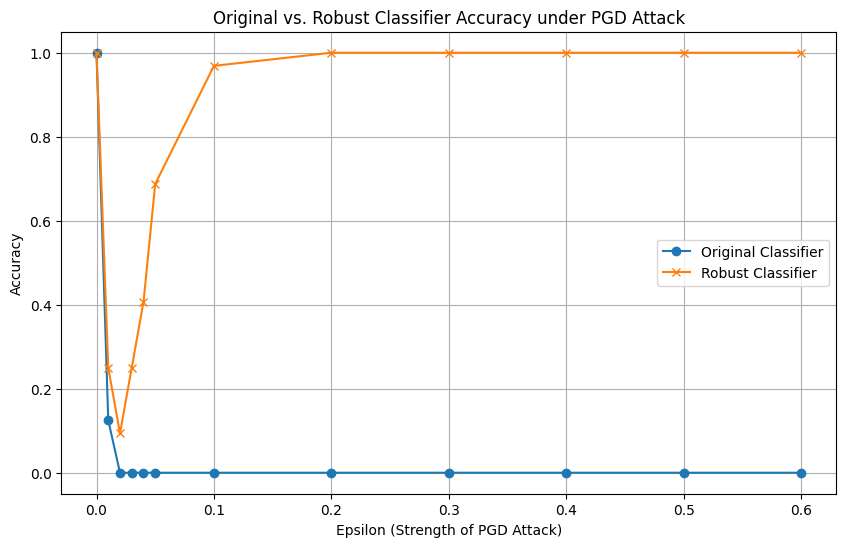

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from tensorflow.keras.losses import CategoricalCrossentropy

# Define epsilon range for the PGD attack
eps_range = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Load the test data (x_test, y_test)
x_test, y_test = next(test_generator)

# Prepare lists to store accuracies for both classifiers
original_accuracies = []
robust_accuracies = []

# Loop over the eps values in eps_range
for eps in eps_range:
    print(f"Generating adversarial examples for eps={eps}")
    
    # Generate adversarial examples using PGD
    pgd_attack = ProjectedGradientDescent(estimator=classifier_original, eps=eps, eps_step=0.01, max_iter=40)
    x_test_adv = pgd_attack.generate(x_test)
    
    # Evaluate original (non-robust) classifier on adversarial examples
    _, original_acc = classifier_original._model.evaluate(x_test_adv, y_test, verbose=0)
    original_accuracies.append(original_acc)
    
    # Evaluate robust classifier on the same adversarial examples
    _, robust_acc = classifier_robust._model.evaluate(x_test_adv, y_test, verbose=0)
    robust_accuracies.append(robust_acc)

# Plot the results: Accuracy vs. Epsilon
plt.figure(figsize=(10, 6))
plt.plot(eps_range, original_accuracies, label="Original Classifier", marker='o')
plt.plot(eps_range, robust_accuracies, label="Robust Classifier", marker='x')
plt.xlabel("Epsilon (Strength of PGD Attack)")
plt.ylabel("Accuracy")
plt.title("Original vs. Robust Classifier Accuracy under PGD Attack")
plt.legend()
plt.grid(True)
plt.show()
